In [ ]:
import numpy as np
import tensorflow as tf
import keras
import gym
from keras import layers, optimizers, losses
import matplotlib.pyplot as plt
import time


In [ ]:
class experience_memory():

    def __init__(self, buffer_capacity, batch_size, state_dim, action_dim):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, state_dim), dtype=np.float32)
        self.action_buffer = np.zeros((self.buffer_capacity, action_dim), dtype=np.float32)
        self.reward_buffer = np.zeros((self.buffer_capacity, 1), dtype=np.float32)
        self.next_state_buffer = np.zeros((self.buffer_capacity, state_dim), dtype=np.float32)
        self.done_buffer = np.zeros((self.buffer_capacity, 1), dtype=np.float32)

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]
        self.done_buffer[index] = obs_tuple[4]

        self.buffer_counter += 1

class Pendulum():

    def __init__(self):

        self.env = gym.make("Pendulum-v1")
        self.batch_size = 32
        self.max_memory_size = 1000000

        self.state_dim = 3
        self.action_dim = 1

        self.gamma = 1
        self.tau = 0.005
        self.lower_action_bound = -2
        self.upper_action_bound = 2

        self.buffer = experience_memory(self.max_memory_size, self.batch_size, self.state_dim, self.action_dim)

       
        # init the neural nets
       
       
        self.critic = self.get_critic_NN()
        self.target_critic = self.get_critic_NN()
        self.target_critic.set_weights(self.critic.get_weights())
        
        self.actor = self.get_actor_NN()
        self.target_actor = self.get_actor_NN()
        self.target_actor.set_weights(self.actor.get_weights())


        self.critic_lr = 0.0002
        self.critic_optimizer = tf.keras.optimizers.Adam(self.critic_lr)
        self.actor_lr = 0.0001
        self.actor_optimizer = tf.keras.optimizers.Adam(self.actor_lr)
      

        self.var = 1
        self.var_decay = 1
        self.lr_decay = 0.9999

       
    
    def update_lr(self):
        self.critic_lr = self.critic_lr * self.lr_decay
        self.critic_optimizer = tf.keras.optimizers.Adam(self.critic_lr)

        self.actor_lr = self.actor_lr * self.lr_decay
        self.actor_optimizer = tf.keras.optimizers.Adam(self.actor_lr)

    def update_var(self):
        self.var = self.var * self.var_decay
    
    @tf.function
    def update_critic(self, state_batch, action_batch, reward_batch, next_state_batch, done_batch):
        target_actions = self.target_actor(next_state_batch)  
        y = reward_batch + (1-done_batch)* self.gamma*self.target_critic([next_state_batch, target_actions])

        with tf.GradientTape() as tape:
            
            critic_value = self.critic([state_batch, action_batch])
            #critic_loss = tf.math.reduce_mean(tf.math.square(y- critic_value))
            critic_loss = losses.huber_loss(y, critic_value)

        
        critic_grad = tape.gradient(critic_loss, self.critic.trainable_variables)
        #critic_grad, _ = tf.clip_by_global_norm(critic_grad, 5.0)
        self.critic_optimizer.apply_gradients(zip(critic_grad, self.critic.trainable_variables))

       
    @tf.function
    def update_actor(self, state_batch, action_batch, reward_batch, next_state_batch, done_batch):
       
        with tf.GradientTape() as tape:
            tape.watch(state_batch)
            actions = self.actor(state_batch)
            critic_value = self.critic([state_batch, actions])

            actor_loss = -tf.math.reduce_mean(critic_value)
        actor_grad = tape.gradient(actor_loss, self.actor.trainable_variables)
        #actor_grad, _ = tf.clip_by_global_norm(actor_grad, 5.0)
        self.actor_optimizer.apply_gradients(
            zip(actor_grad, self.actor.trainable_variables)
        )

   
    
        
    def learn(self):
        # get sample

        record_range = min(self.buffer.buffer_counter, self.buffer.buffer_capacity)

        batch_indices = np.random.choice(record_range, self.batch_size)

        state_batch = tf.convert_to_tensor(self.buffer.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.buffer.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.buffer.reward_buffer[batch_indices])
        next_state_batch = tf.convert_to_tensor(self.buffer.next_state_buffer[batch_indices])

        done_batch = tf.convert_to_tensor(self.buffer.done_buffer[batch_indices])
        
        self.update_critic(state_batch, action_batch, reward_batch, next_state_batch, done_batch)

       
        self.update_actor(state_batch, action_batch, reward_batch, next_state_batch, done_batch)


    @tf.function
    def update_target(self, target_weights, weights):
        for (a,b) in zip(target_weights, weights):
            a.assign(self.tau *b + (1-self.tau) *a)

        
    def get_critic_NN(self):
        # input [state, action]
        last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
        state_input = layers.Input(shape =(self.state_dim,))

        
        state_out = layers.Dense(128, activation='relu')(state_input)
        state_out = layers.BatchNormalization()(state_out)
        state_out = layers.Dense(256, activation ='relu')(state_out)

        action_input = layers.Input(shape = (self.action_dim,))
        action_out = layers.Dense(256, activation = 'relu')(action_input)
        action_out = layers.BatchNormalization()(action_out)

        concat = layers.Concatenate()([state_out, action_out])

        out = layers.Dense(512, activation = 'relu')(concat)
        out = layers.Dense(512, activation = 'relu')(out)
        out = layers.Dense(1, kernel_initializer= last_init)(out)

        model = keras.Model(inputs = [state_input, action_input], outputs = out)

        return model

    def get_actor_NN(self):
        
        # Initialize weights between -3e-3 and 3-e3
        last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

        inputs = layers.Input(shape=(self.state_dim,))
       
        out = layers.Dense(1024, activation="relu")(inputs)
        out = layers.BatchNormalization()(out)
        out = layers.Dense(512, activation="relu")(out)
        outputs = layers.Dense(1, activation='tanh', kernel_initializer=last_init)(out)

        # Our upper bound is 2.0 .
        outputs = outputs * self.upper_action_bound
        model = tf.keras.Model(inputs, outputs)
        return model

    def policy(self, state):
        sampled_actions = tf.squeeze(self.actor(state))
        
        #noice = self.noice_Obj()
      
        sampled_actions = sampled_actions + np.random.normal(loc= 0, scale=self.var)

        legal_action = np.clip(sampled_actions, self.lower_action_bound, self.upper_action_bound)

        return [np.squeeze(legal_action)]
        #return [np.squeeze(sampled_actions)]
    
    @tf.function
    def target_policy(self, state):
        sampled_actions = self.target_actor(state)
        
        #noice = self.noice_Obj()

        sampled_actions = sampled_actions + tf.random.normal(shape = sampled_actions.get_shape(), mean = 0.0, stddev = 0.1, dtype = tf.float32)
        
        legal_action = tf.clip_by_value(sampled_actions, clip_value_min = self.lower_action_bound, clip_value_max =self.upper_action_bound)

        return legal_action

Episode * 0 * Avg Reward is ==> -1359.7525345975996, var ==> 1, actor_lr ==> 0.0001
Episode * 1 * Avg Reward is ==> -1530.406224434499, var ==> 1, actor_lr ==> 0.0001
Episode * 2 * Avg Reward is ==> -1448.7647501112758, var ==> 1, actor_lr ==> 0.0001
Episode * 3 * Avg Reward is ==> -1413.6300397443101, var ==> 1, actor_lr ==> 0.0001
Episode * 4 * Avg Reward is ==> -1304.1050292703903, var ==> 1, actor_lr ==> 0.0001
Episode * 5 * Avg Reward is ==> -1303.6769179589853, var ==> 1, actor_lr ==> 0.0001
Episode * 6 * Avg Reward is ==> -1246.170901886425, var ==> 1, actor_lr ==> 0.0001
Episode * 7 * Avg Reward is ==> -1223.7864157849826, var ==> 1, actor_lr ==> 0.0001
Episode * 8 * Avg Reward is ==> -1269.2733476899775, var ==> 1, actor_lr ==> 0.0001
Episode * 9 * Avg Reward is ==> -1282.8228546450096, var ==> 1, actor_lr ==> 0.0001
Episode * 10 * Avg Reward is ==> -1295.921795966477, var ==> 1, actor_lr ==> 0.0001
Episode * 11 * Avg Reward is ==> -1261.9157810925, var ==> 1, actor_lr ==> 0.0

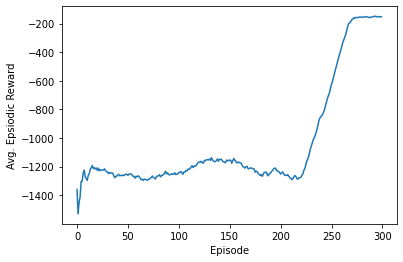

In [ ]:
MC = Pendulum()

ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []
num_episode = 300
decay = 0.9999
for ep in range(num_episode):
    
    done = False
    state = MC.env.reset()
    #state = tf.expand_dims(tf.convert_to_tensor(state),0)
    
    state = np.reshape(state, [1,MC.state_dim])
    episodic_reward = 0
    t_counter = 0

    #if (ep % 100 == 0 and ep != 0):
        #MC.run_MC()
    while(t_counter < 200):
        
        
        action = MC.policy(state)
        
        new_state, reward, done, info = MC.env.step(action)
        
        #new_state = tf.expand_dims(tf.convert_to_tensor(new_state.reshape(MC.state_dim)),0)
       
        new_state = np.reshape(new_state, [1,MC.state_dim])
        episodic_reward += reward
        
        MC.buffer.record((state,action,reward, new_state, done))
        if (ep >= 200):
          MC.var = 0.1
          MC.learn()
    
          if (t_counter % 2 == 0 and t_counter != 0):
                  
              MC.update_target(MC.target_critic.variables,MC.critic.variables)
            
              MC.update_target(MC.target_actor.variables, MC.actor.variables)
        

        state = new_state

        t_counter +=1
        if (done):
            break
    ep_reward_list.append(episodic_reward)
    # Mean of last 40 episodes
    avg_reward = np.mean(ep_reward_list[-50:])
    print("Episode * {} * Avg Reward is ==> {}, var ==> {}, actor_lr ==> {}".format(ep, avg_reward, MC.var, MC.actor_lr))
    avg_reward_list.append(avg_reward)
# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

